In [1]:
import fun as f
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import networkx as nx
import scipy.linalg as la
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from IPython.display import Image

# A, B. Similarity Graphs and Matrices derived from graphs

# 1- Half-moon Dataset:

In [2]:
#Generate data
Npts = 35
half_moons_data = datasets.make_moons(n_samples=Npts, noise=.040, random_state=1991)
nodes_position = dict()
for key  in [i for i in range(Npts)]:
    nodes_position[key] = list(half_moons_data[0][key])

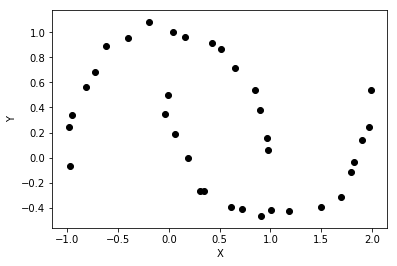

In [3]:
#plot data
f.scatter_plot_data_set(half_moons_data[0], half_moons_data[1],False)

## i) Fully connected graph 

In [4]:
small_sigma = 0.05
W_half_moon = f.adjacency_matrix(half_moons_data[0], sigma=small_sigma)

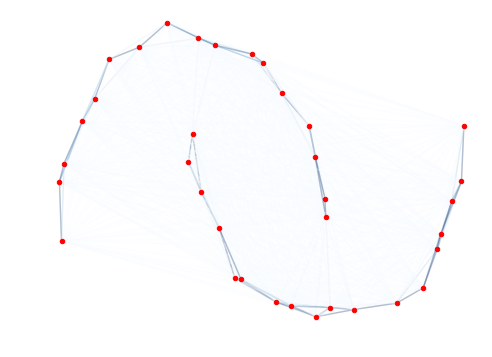

In [6]:
#create graph
hm = f.create_weighted_Graph(W_half_moon)
#Plot graph
f.plot_Graph(hm, nodes_position, title = '',alpha=0.3, output_file_name="fully_connected_graph")

In [7]:
eigenvalues_m, eigenvectors_m = la.eig(f.unnormalized_graph_Laplacian(W_half_moon))
eigenvalues_m=eigenvalues_m.real
rearrangedEvalsVecs_moon_data = sorted(zip(eigenvalues_m,eigenvectors_m.T),key=lambda x: x[0])
eigenvalues_m.sort()

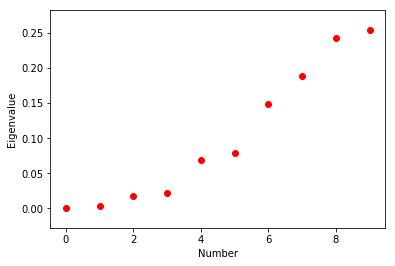

In [8]:
plt.scatter([i for i in range(10)], eigenvalues_m[0:10],c="red")
plt.xlabel ('Number')
plt.ylabel ('Eigenvalue')
plt.show()

In [9]:
Image(url='gif.gif')

## ii) Mutual k-nearest neighbor graph

In [10]:
A = kneighbors_graph(half_moons_data[0], 3, mode='connectivity', include_self=False)
A= A.toarray()

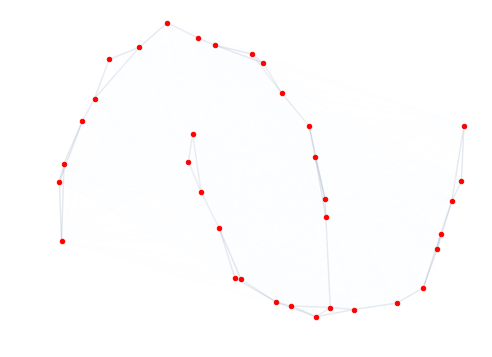

In [12]:
#create graph
km = f.create_weighted_Graph(A)
#Plot graph
f.plot_Graph(km, nodes_position, title = '',edge_vmax=1e-3,alpha=0.1)

# 2- Spiral Dataset

In [13]:
# Toy dataset obtained from:
# https://www.gagolewski.com/resources/data/clustering/
data_path = 'data/spiral.data'
labels_path = 'data/spiral.labels'

In [14]:
data_points, data_labels = f.read_and_convert_data(data_path, labels_path)
Npts, coord = data_points.shape
nodes_position_spiral = dict()
for key  in [i for i in range(Npts)]:
    nodes_position_spiral[key] = list(data_points[key])

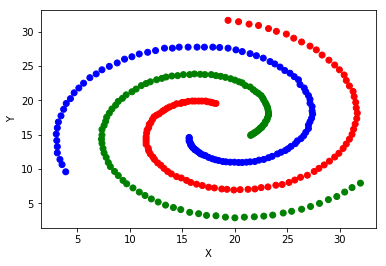

In [15]:
f.scatter_plot_data_set(data_points, data_labels)

In [16]:
W = f.adjacency_matrix(data_points, sigma=0.5)

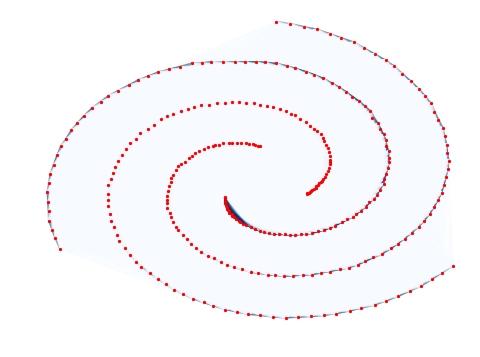

In [18]:
#create graph
spiral_graph = f.create_weighted_Graph(W)
#Plot graph
f.plot_Graph(spiral_graph, nodes_position_spiral, 
               title = '',node_size=5,edge_vmax=1e-8,alpha=0.2)

In [19]:
#Compute the unnormalized graph Laplacian Matrix
L_unnormalized = f.unnormalized_graph_Laplacian(W)

#Sanity check: Symmetric matrix
L_unnormalized.shape
np.allclose(L_unnormalized, L_unnormalized.T)
#np.matmul(L_unnormalized, np.ones(L_unnormalized.shape[0]).reshape(L_unnormalized.shape[0], 1))

True

## Compute eigenvalues-eigenvectors

In [20]:
eigenvalues, eigenvectors = la.eig(L_unnormalized)
eigenvalues = eigenvalues.real
rearrangedEvalsVecs = sorted(zip(eigenvalues,eigenvectors.T),key=lambda x: x[0])
eigenvalues.sort()

## Multiplicity of the first eigenvalue

In [21]:
multiplicity_k = (np.where(eigenvalues < 1e-8)[0].shape[0])
multiplicity_k

3

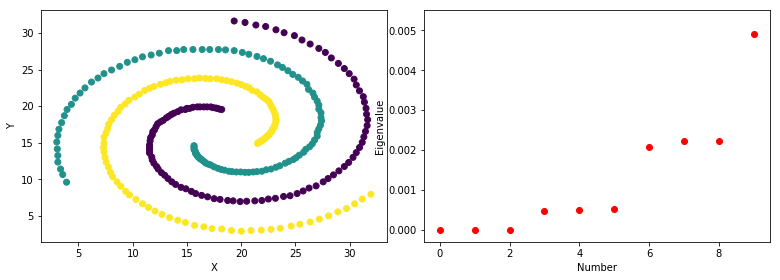

In [22]:
x, y = data_points.T
fig = plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
plt.tight_layout()
plt.scatter(x,y,c=data_labels)
plt.xlabel("X")
plt.ylabel("Y")

plt.subplot(1, 2, 2)
plt.tight_layout()
plt.scatter([i for i in range(10)], eigenvalues[0:10],c="red")
plt.ylim(-0.0003, 0.0055)
plt.xlabel ('Number')
plt.ylabel ('Eigenvalue')

plt.show()

### In the second and third eigenvectors, why do we move from one to two steps?

### Why does the projection of the 2nd 3rd eigenvector components are overlap into a single point?

### How about the rest of eigenvectors?

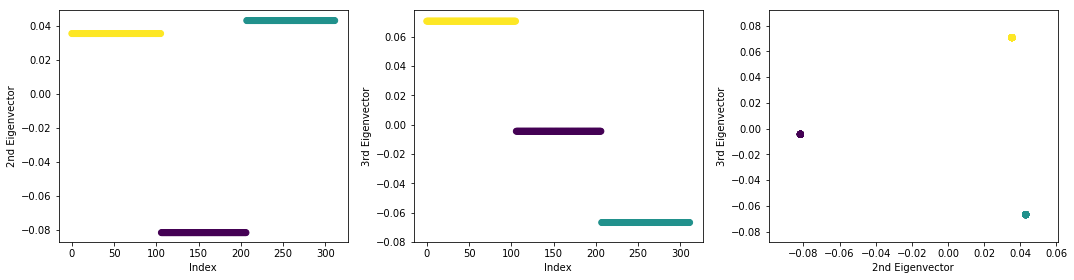

In [23]:
fig = plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.tight_layout()
plt.scatter([i for i in range(Npts)], rearrangedEvalsVecs[1][1],c=data_labels)
plt.xlabel ('Index')
plt.ylabel ('2nd Eigenvector')
plt.ylim(-0.087, 0.049)

plt.subplot(1, 3, 2)
plt.tight_layout()
plt.scatter([i for i in range(Npts)], rearrangedEvalsVecs[2][1],c=data_labels)
plt.xlabel ('Index')
plt.ylabel ('3rd Eigenvector')
plt.ylim(-0.08, 0.078)

plt.subplot(1, 3, 3)
plt.tight_layout()
plt.scatter(rearrangedEvalsVecs[1][1], rearrangedEvalsVecs[2][1],c=data_labels)
plt.xlabel ('2nd Eigenvector')
plt.ylabel ('3rd Eigenvector')

plt.show()

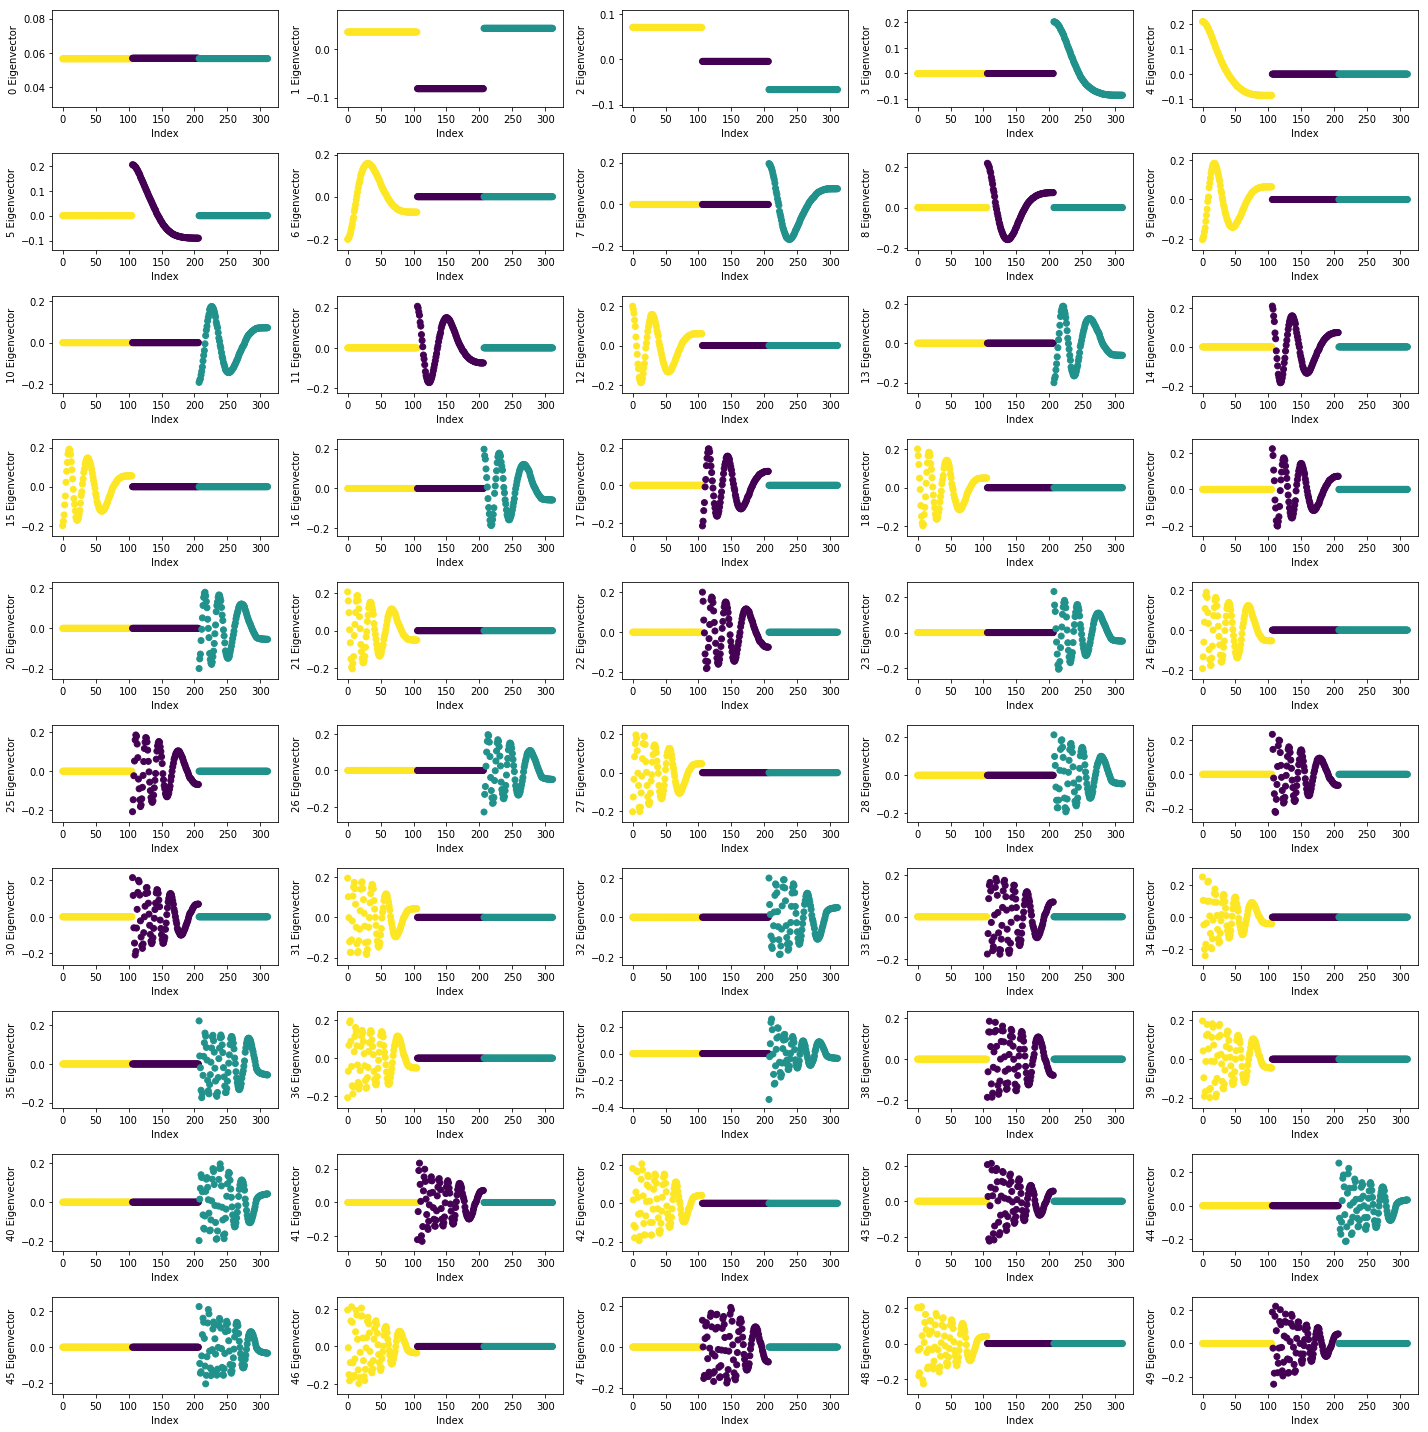

In [24]:
fig = plt.figure(figsize=(20, 20))
for i in range(50):      
    plt.subplot(10, 5, i+1)
    plt.tight_layout()
    plt.scatter([i for i in range(Npts)], rearrangedEvalsVecs[i][1],c=data_labels)
    y_label = str(i)+' Eigenvector'
    plt.ylabel (y_label)
    plt.xlabel ('Index')

# IV. The algorithm

## 1. Spiral data set:

In [25]:
#New data coordinates:
V = np.zeros((len(rearrangedEvalsVecs), multiplicity_k-1))
V[:,0]=rearrangedEvalsVecs[1][1]
V[:,1]=rearrangedEvalsVecs[2][1]

#K-means performance before the change of representation of the data:
kmeans_spiral_data_coord = KMeans(n_clusters=3,random_state=0).fit(data_points)
#K-means performance after the change of representation of the data:
kmeans_new_spiral_data_coord = KMeans(n_clusters=3,random_state=0).fit(V)


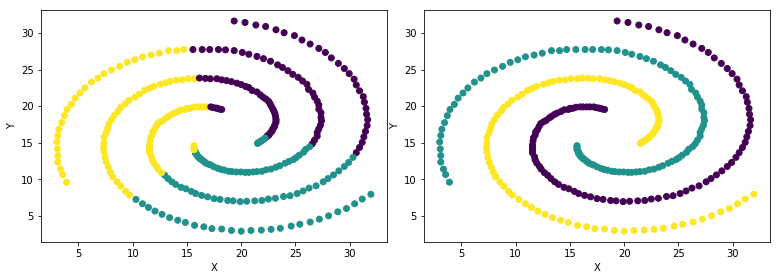

In [26]:
x, y = data_points.T
fig = plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
plt.tight_layout()
plt.scatter(x,y,c=kmeans_spiral_data_coord.labels_)
plt.xlabel("X")
plt.ylabel("Y")

plt.subplot(1, 2, 2)
plt.tight_layout()
plt.scatter(x,y,c=kmeans_new_spiral_data_coord.labels_)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## 2- Half moon data set

In [27]:
Npts_moon=len(half_moons_data[0])
rearranged2ndEigenVec_moon_data = sorted(
    zip(rearrangedEvalsVecs_moon_data[1][1],half_moons_data[1]),
    key=lambda x: x[0])

#New data coordinates:
V = np.zeros((len(rearrangedEvalsVecs_moon_data), 2))
V[:,0]=rearrangedEvalsVecs_moon_data[1][1]
V[:,1]=rearrangedEvalsVecs_moon_data[2][1]

#K-means performance before the change of representation of the data:
kmeans_moon_data_coord = KMeans(n_clusters=2,random_state=0).fit(half_moons_data[0])
#K-means performance after the change of representation of the data:
kmeans_new_moon_data_coord = KMeans(n_clusters=2,random_state=0).fit(V)


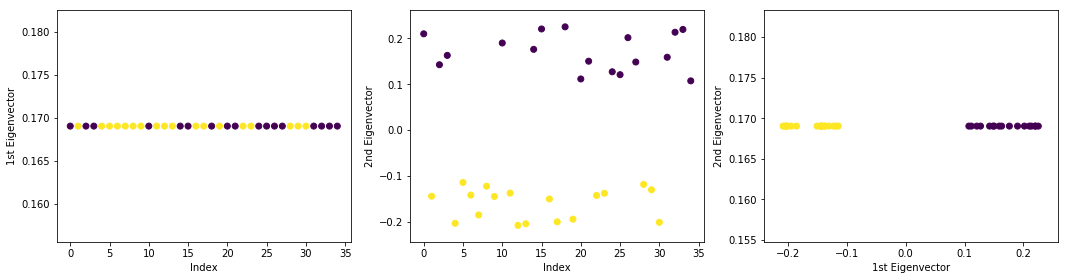

In [28]:
fig = plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.tight_layout()
plt.scatter([i for i in range(Npts_moon)], 
            rearrangedEvalsVecs_moon_data[0][1],c=half_moons_data[1])
plt.ylabel ('1st Eigenvector')
plt.xlabel ('Index')

plt.subplot(1, 3, 2)
plt.tight_layout()
plt.scatter([i for i in range(Npts_moon)], 
            rearrangedEvalsVecs_moon_data[1][1],c=half_moons_data[1])
plt.ylabel ('2nd Eigenvector')
plt.xlabel ('Index')

plt.subplot(1, 3, 3)
plt.tight_layout()
plt.scatter(rearrangedEvalsVecs_moon_data[1][1], 
            rearrangedEvalsVecs_moon_data[0][1],c=half_moons_data[1])
plt.xlabel ('1st Eigenvector')
plt.ylabel ('2nd Eigenvector')
plt.show()

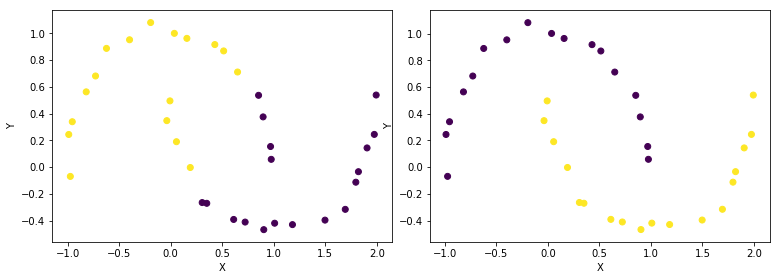

In [29]:
x, y = half_moons_data[0].T
fig = plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
plt.tight_layout()
plt.scatter(x,y,c=kmeans_moon_data_coord.labels_)
plt.xlabel("X")
plt.ylabel("Y")

plt.subplot(1, 2, 2)
plt.tight_layout()
plt.scatter(x,y,c=kmeans_new_moon_data_coord.labels_)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# VII. Demostrative Examples:

## A. Imbalanced data set

In [30]:
#Create data points
Npts_imb = 60
Nclusters = 2
np.random.seed(7)
data_coordinates = np.random.normal(loc=0.0, scale=1.0, size=(Npts_imb, 2))
#Assign randomly each datapoint to a cluster
labels = np.random.choice(list(range(Nclusters)),size=Npts_imb,replace=True, p=[0.15,0.85])

In [31]:
#Assign each cluster a mean.
data_means = np.zeros((2,2))
data_means[0,] = [6,5]
data_means[1,] = [11,6]
#Shift the points towards the mean
clusterd_data =data_coordinates+data_means[labels,]

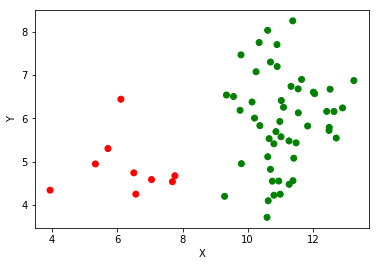

In [32]:
#Plot the data
f.scatter_plot_data_set(clusterd_data, labels)

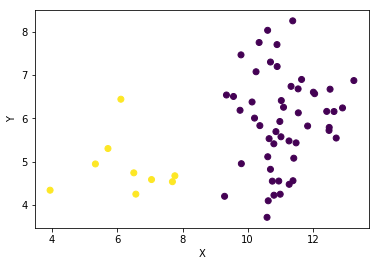

In [33]:
#K-means performance before the change of representation of the data:
kmeans_umbalanced_data = KMeans(n_clusters=2,random_state=0).fit(clusterd_data)

plt.scatter(clusterd_data[:,0],clusterd_data[:,1],c=kmeans_umbalanced_data.labels_)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [34]:
W_umbalanced_data = f.adjacency_matrix(clusterd_data, sigma=2)

In [35]:
eigenvalues_umb_data, eigenvectors_umb_data = la.eig(f.unnormalized_graph_Laplacian(W_umbalanced_data))
eigenvalues_umb_data = eigenvalues_umb_data.real
rearrangedEvalsVecs_umb_data = sorted(zip(eigenvalues_umb_data,eigenvectors_umb_data.T),key=lambda x: x[0])
eigenvalues_umb_data.sort()

In [36]:
rearranged2ndEigenVec_umb_data = sorted(
    zip(rearrangedEvalsVecs_umb_data[1][1],labels),
    key=lambda x: x[0])

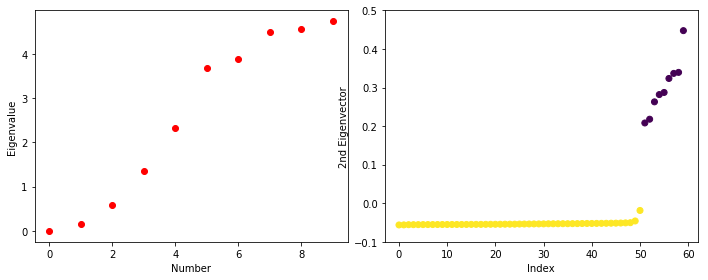

In [37]:
fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.tight_layout()

plt.scatter([i for i in range(10)], eigenvalues_umb_data[0:10],c="red")
plt.xlabel ('Number')
plt.ylabel ('Eigenvalue')

plt.subplot(1, 2, 2)
plt.tight_layout()
plt.scatter([i for i in range(60)], [rearranged2ndEigenVec_umb_data[i][0] for i in range(60)],
            c=[rearranged2ndEigenVec_umb_data[i][1] for i in range(60)])
plt.ylim(-0.1,0.5)
plt.xlabel ('Index')
plt.ylabel ('2nd Eigenvector')
plt.show()

## B. Detecting the number of clusters - hirarchical organizations in the data set

In [38]:
#Create data points
Npts_imb = 100
Nclusters = 4
np.random.seed(1991)
data_coordinates = np.random.normal(loc=0.0, scale=1.0, size=(Npts_imb, 2))
#Assign randomly each datapoint to a cluster
labels = np.random.choice(list(range(Nclusters)),size=Npts_imb,replace=True, p=[0.35,0.15,0.35,0.15])

In [39]:
#Assign each cluster a mean.
data_means = np.zeros((4,2))
data_means[0,] = [6.5,2.5]
data_means[1,] = [6.5,9.5]
data_means[2,] = [-5,2]
data_means[3,] = [-6,8.58]
#Shift the points towards the mean
clusterd_data =data_coordinates+data_means[labels,]

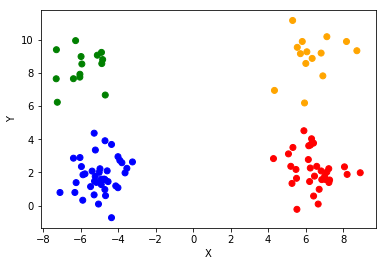

In [40]:
#Plot the data with original labels
f.scatter_plot_data_set(clusterd_data, labels)

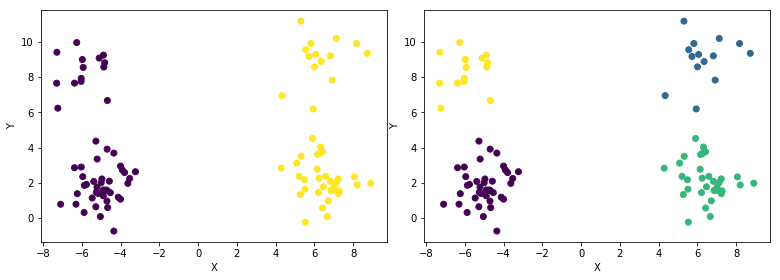

In [41]:
#K-means performance before the change of representation of the data:
kmeans_non_hirarchical = KMeans(n_clusters=2,random_state=0).fit(clusterd_data)
kmeans_hirarchical = KMeans(n_clusters=4,random_state=0).fit(clusterd_data)

fig = plt.figure(figsize=(11, 4))

#Plot data
plt.subplot(1, 2, 1)
plt.tight_layout()
plt.scatter(clusterd_data[:,0],clusterd_data[:,1],c=kmeans_non_hirarchical.labels_)
plt.xlabel("X")
plt.ylabel("Y")

#Plot sorted eigenvectors
plt.subplot(1, 2, 2)
plt.tight_layout()
plt.scatter(clusterd_data[:,0],clusterd_data[:,1],c=kmeans_hirarchical.labels_)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [42]:
W_umbalanced_data = f.adjacency_matrix(clusterd_data, sigma=10)

In [43]:
eigenvalues_umb_data, eigenvectors_umb_data = la.eig(f.unnormalized_graph_Laplacian(W_umbalanced_data))
eigenvalues_umb_data.sort()
eigenvalues_umb_data=eigenvalues_umb_data.real

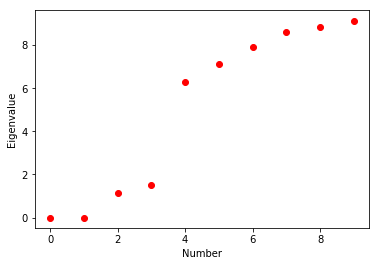

In [44]:
plt.scatter([i for i in range(10)], eigenvalues_umb_data[0:10],c="red")
plt.xlabel ('Number')
plt.ylabel ('Eigenvalue')
plt.show()

## C. Sensitivity to parameter selection

In [45]:
large_sigma = 0.1
W_half_moon_large_sigma = f.adjacency_matrix(half_moons_data[0], sigma=large_sigma)
eigenvalues_large_sigma, eigenvectors_large_sigma = la.eig(
    f.unnormalized_graph_Laplacian(W_half_moon_large_sigma))
eigenvalues_large_sigma=eigenvalues_large_sigma.real

rearrangedEvalsVecs_moon_data_large_sigma = sorted(
    zip(eigenvalues_large_sigma,eigenvectors_large_sigma.T),key=lambda x: x[0])
eigenvalues_large_sigma.sort()

rearranged2ndEigenVec_moon_data_large_sigma = sorted(
    zip(rearrangedEvalsVecs_moon_data_large_sigma[1][1],half_moons_data[1]),
    key=lambda x: x[0])

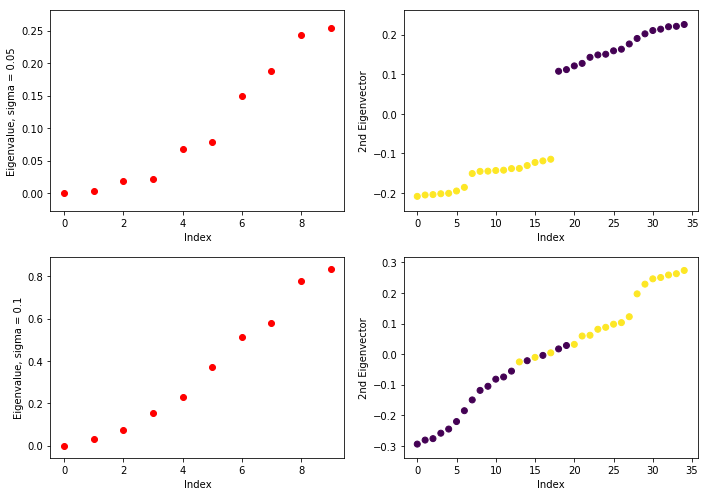

In [46]:
fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 2, 1)
plt.tight_layout()

plt.scatter([i for i in range(10)], eigenvalues_m[0:10],c="red")
plt.xlabel ('Index')
ylabel = "Eigenvalue, sigma = " +str(small_sigma)
plt.ylabel (ylabel)

plt.subplot(2, 2, 2)
plt.tight_layout()
plt.scatter([i for i in range(Npts_moon)], 
            [rearranged2ndEigenVec_moon_data[i][0] for i in range(Npts_moon)],
            c=[rearranged2ndEigenVec_moon_data[i][1] for i in range(Npts_moon)])
plt.xlabel ('Index')
plt.ylabel ('2nd Eigenvector')

plt.subplot(2, 2, 3)
plt.tight_layout()
plt.scatter([i for i in range(10)], eigenvalues_large_sigma[0:10],c="red")
plt.xlabel ('Index')
ylabel = "Eigenvalue, sigma = " +str(large_sigma)
plt.ylabel (ylabel)

plt.subplot(2, 2, 4)
plt.tight_layout()
plt.tight_layout()
plt.scatter([i for i in range(Npts_moon)], 
            [rearranged2ndEigenVec_moon_data_large_sigma[i][0] for i in range(Npts_moon)],
            c=[rearranged2ndEigenVec_moon_data_large_sigma[i][1] for i in range(Npts_moon)])
plt.xlabel ('Index')
plt.ylabel ('2nd Eigenvector')
plt.show()

## 3- Circles data set

In [47]:
# Generate data set:
Npts_list = [400, 250, 70]
rad_list = [10, 6, 2]
lower_boundry_list=[0.7, 0.5, 0.3]
circle_data_points = f.generate_3circles_data_set(Npts_list, rad_list,lower_boundry_list, seed=1991)

In [48]:
#Generate adjacency matrix:
W_circles_dataset = f.adjacency_matrix(circle_data_points[:,0:2], sigma=1)
#Generate the Normalized symmetric graph Laplacian matrix:
L_normalized_circles_dataset = f.normalized_graph_Laplacian(W_circles_dataset, matrix = "symmetric")

#Compute eigenvalues/eigenvectors
eigenvalues_circles_dataset, eigenvectors_circles_dataset = la.eig(L_normalized_circles_dataset)
eigenvalues_circles_dataset = eigenvalues_circles_dataset.real

#Create dictionary with sorting the eigenvalues
dic_EvalsEvecs_circle_data = sorted(
    zip(eigenvalues_circles_dataset,eigenvectors_circles_dataset.T),key=lambda x: x[0])
eigenvalues_circles_dataset.sort()

### Multiplicity of the first eigenvalue

In [49]:
#Determine the number of clusters
multiplicity_k = np.where(eigenvalues_circles_dataset <= 1e-3)[0].shape[0]

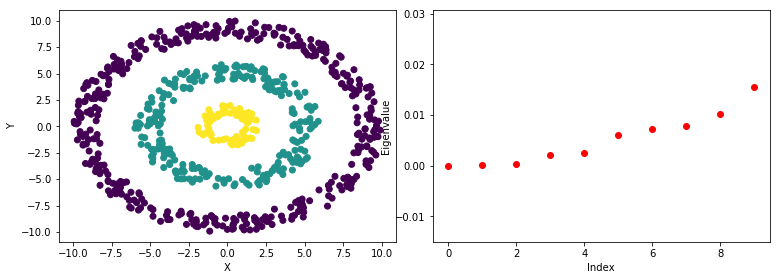

In [50]:
x, y,z = circle_data_points.T
fig = plt.figure(figsize=(11, 4))

#Plot data
plt.subplot(1, 2, 1)
plt.tight_layout()
plt.scatter(x,y,c=z)
plt.xlabel("X")
plt.ylabel("Y")

#Plot sorted eigenvectors
plt.subplot(1, 2, 2)
plt.tight_layout()
plt.scatter([i for i in range(10)], eigenvalues_circles_dataset[0:10],c="red")
plt.xlabel ('Index')
plt.ylabel ('Eigenvalue')
plt.show()


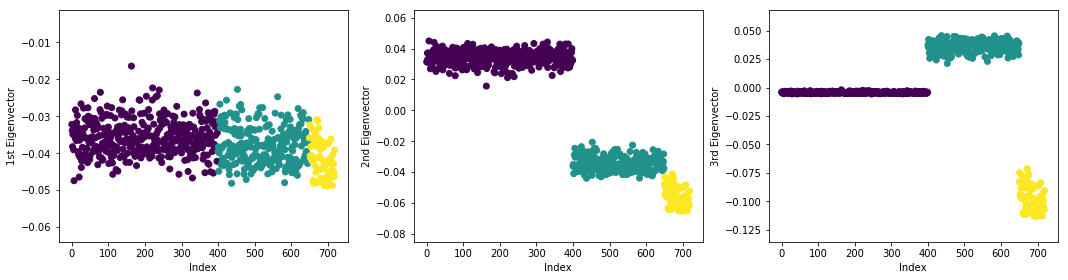

In [51]:
fig = plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.tight_layout()
plt.scatter([i for i in range(len(dic_EvalsEvecs_circle_data))], 
            dic_EvalsEvecs_circle_data[0][1],c=z)
plt.xlabel ('Index')
plt.ylabel ('1st Eigenvector')

plt.subplot(1, 3, 2)
plt.tight_layout()
plt.scatter([i for i in range(len(dic_EvalsEvecs_circle_data))], 
            dic_EvalsEvecs_circle_data[1][1],c=z)
plt.xlabel ('Index')
plt.ylabel ('2nd Eigenvector')

plt.subplot(1, 3, 3)
plt.tight_layout()
plt.scatter([i for i in range(len(dic_EvalsEvecs_circle_data))],
            dic_EvalsEvecs_circle_data[2][1],c=z)
plt.xlabel ('Index')
plt.ylabel ('3rd Eigenvector')

plt.show()

# The algorithm:

In [52]:
#New data coordinates:
V = np.zeros((len(dic_EvalsEvecs_circle_data), multiplicity_k-1))
V[:,0]=dic_EvalsEvecs_circle_data[1][1]
V[:,1]=dic_EvalsEvecs_circle_data[2][1]

#K-means performance before the change of representation of the data:
kmeans_spiral_data_coord = KMeans(n_clusters=3,random_state=0).fit(circle_data_points[:,0:2])
#K-means performance after the change of representation of the data:
kmeans_new_spiral_data_coord = KMeans(n_clusters=3,random_state=0).fit(V)


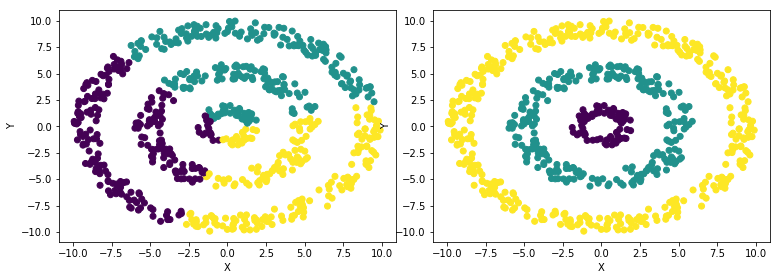

In [53]:
fig = plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
plt.tight_layout()
plt.scatter(x,y,c=kmeans_spiral_data_coord.labels_)
plt.xlabel("X")
plt.ylabel("Y")

plt.subplot(1, 2, 2)
plt.tight_layout()
plt.scatter(x,y,c=kmeans_new_spiral_data_coord.labels_)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# VIII. Validation - Circles dataset

## Pearson correlation coefficient with a *similarity matrix* defined by the Euclidean distance:

In [54]:
incidence_matrix = f.incidence_matrix(z)
similarity_matrix_eucledian_d = f.distance_matrix(circle_data_points[:,0:2], "eucledian_dist")

In [55]:
f.correlation_coefficient(incidence_matrix, similarity_matrix_eucledian_d)

0.09362574783855335

## Pearson correlation coefficient with a *similarity matrix* defined by the Euclidean Commute Time Distance:

In [56]:
similarity_matrix_CTD = f.distance_matrix(dic_EvalsEvecs_circle_data,"commute_time_distance", W_circles_dataset)
f.correlation_coefficient(incidence_matrix, similarity_matrix_CTD)

-0.8625057567903386